Этот рекомендатель основан на наборе данных movie lens, представленных на [kaggle](https://inclass.kaggle.com/c/movie)

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix, dok_matrix
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('training_ratings_for_kaggle_comp.csv', index_col = 'id')
df[['rating']] = df[['rating']].astype('float')
df.describe()

,user,movie,rating
count,500100.000000,500100.000000,500100.000000
mean,4408.620518,1834.281214,3.602224
std,926.274862,1076.388887,1.114688
min,2783.000000,1.000000,1.000000
25%,3622.000000,1022.000000,3.000000
50%,4371.000000,1767.000000,4.000000
75%,5220.000000,2724.000000,4.000000
max,6040.000000,3952.000000,5.000000


В обучающей выборке представлены оценки только для пользователей, начиная с номера 2783, а предсказания нужно делать для всех 6040 пользователей, значит, случаи с "новыми" пользователями нужно обрабатывать особо.

In [3]:
movies_with_ratings = df['movie'].unique()
len(movies_with_ratings)

3551

Кроме того, есть фильмы без оценок.

In [4]:
number_of_ratings = df['user'].groupby(df['movie']).count()
number_of_ratings.describe()

count    3551.000000
mean      140.833568
std       200.241913
min         1.000000
25%        18.000000
50%        66.000000
75%       181.000000
max      1684.000000
Name: user, dtype: float64

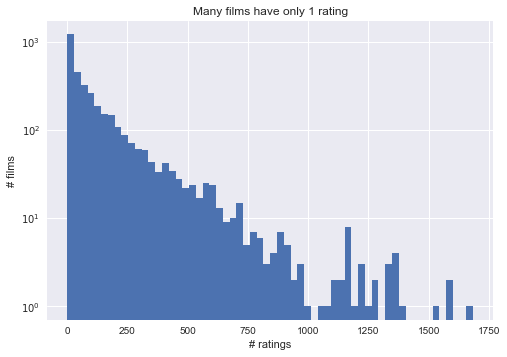

In [44]:
plt.hist(number_of_ratings, bins = 60, log = True);
plt.title('Many films have only 1 rating')
plt.ylabel('# films')
plt.xlabel('# ratings')
plt.show()

У большого количества фильмов мало оценок. Фильмы с малым количеством оценок стоит считать как фильмы без оценок, так как их средняя оценка искажена. Теперь подготовим данные пользователей и фильмов.

In [98]:
# movies = pd.read_csv('movies.dat',  sep = '::', index_col = 0, header = None, names = ['name', 'genre'], engine = 'python' )
# movies.head()

,name,genre
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [6]:
movies = pd.read_csv('movies.dat',  sep = '::', index_col = 0, header = None, names = ['name', 'genre'], engine = 'python' )
genres = ['Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

# Создадим признаки фильмов -- среднюю оценку, год и т.п.
movies['avg']=df['rating'].groupby(df['movie']).mean()
movies['genre'] = movies['genre'].str.split('|')
movies = movies.reindex(columns = ['name', 'genre', 'avg', 'year']+genres)

for ix, row in movies.iterrows():
    # Нормируем, чтобы значения не были значительно больше других признаков
    year = int(row['name'][-5:-1])/2020.0
    movies.loc[ix, 'year'] = year
    # Считаем term frequency жанров для фильма   
    tf = len(row['genre'])**(-1)
    for genre in row['genre']:
        movies.loc[ix, genre] = tf
movies.fillna(0, inplace=True)

for genre in genres:
    genre_movies = movies[movies[genre]>0].index.tolist()
    movies[genre+'_avg'] = df.loc[df['movie'].isin(genre_movies),'rating'].mean()
# TFIDF по жанрам как профиль фильма
    movies[genre]*=np.log(3952/movies.loc[movies[genre]>0,genre].count())
movies.head(1)

,name,genre,avg,year,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy_avg,Film-Noir_avg,Horror_avg,Musical_avg,Mystery_avg,Romance_avg,Sci-Fi_avg,Thriller_avg,War_avg,Western_avg
1,Toy Story (1995),"[Animation, Children's, Comedy]",4.14663,0.987624,0.0,0.0,1.209339,0.918841,0.3973,0.0,...,3.473889,4.083638,3.237581,3.680531,3.699951,3.627256,3.492792,3.606233,3.907507,3.672569


Теперь пользователи

In [58]:
# users = pd.read_csv('users.dat', sep = '::', index_col = 0, header = None, names = ['sex', 'age', 'job', 'zip'], engine = 'python')
# users.head()

,sex,age,job,zip
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455


Zip сам по себе бесполезен, слишком много значений. Польза может быть, если сгруппировать индексы по городам или штатам -- возможно, когда-нибудь.

In [7]:
users = pd.read_csv('users.dat', sep = '::', index_col = 0, header = None, names = ['sex', 'age', 'job', 'zip'], engine = 'python')
users.drop('zip', 1, inplace  = True)

users['mean']=df['rating'].groupby(df['user']).mean()
users['mean'].fillna(users['mean'].mean(), inplace=True)
users['std']=df['rating'].groupby(df['user']).std()
users['std'].fillna(users['std'].mean(), inplace=True)
users['sex'].replace(['F','M'],[0, 1], inplace = True)
users['age']/=56


good_df = df[df['rating'] > 3]
bad_df = df[df['rating'] <= 3]
for genre in genres:
#     Берём все фильмы данного жанра
    genre_movies = movies[movies[genre]>0].index.tolist()
    
#     Количество просмотров фильмов данного жанра, которые понравились
    user_genre_watch_good = good_df.loc[good_df['movie'].isin(genre_movies),'user'].groupby(good_df['user']).count()
    
#     и которые не понравились
    user_genre_watch_bad = bad_df.loc[bad_df['movie'].isin(genre_movies),'user'].groupby(bad_df['user']).count()
    
#     вероятность того, что фильм жанра понравится
    prob = user_genre_watch_good / (user_genre_watch_good + user_genre_watch_bad)
    
#     запишем это в таблицу
    users.loc[:,'like_'+genre] = prob
    
#     забьем пустые значения
    med_prob = user_genre_watch_good.median() / (user_genre_watch_good.median() + user_genre_watch_bad.median())
    users.loc[:,'like_'+genre].fillna(med_prob,inplace = True)
    
#     Средний рейтинг жанра
    user_genre_rating = df.loc[df['movie'].isin(genre_movies),'rating'].groupby(df['user']).mean()
    users.loc[:,genre+'_mean'] = user_genre_rating
    users.loc[:,genre+'_mean'].fillna(movies.loc[1,genre+'_avg'], inplace=True)
users = pd.get_dummies(users, columns = ['job'])

users.tail()

,sex,age,mean,std,like_Action,Action_mean,like_Adventure,Adventure_mean,like_Animation,Animation_mean,...,job_11,job_12,job_13,job_14,job_15,job_16,job_17,job_18,job_19,job_20
6036,0,0.446429,3.302928,1.023684,0.292208,3.000000,0.253012,2.987952,0.647059,3.911765,...,0,0,0,0,1,0,0,0,0,0
6037,0,0.803571,3.717822,0.877910,0.571429,3.642857,0.888889,4.000000,0.600000,4.000000,...,0,0,0,0,0,0,0,0,0,0
6038,0,1.000000,3.800000,1.105013,0.500000,3.000000,0.583333,4.000000,0.666667,3.666667,...,0,0,0,0,0,0,0,0,0,0
6039,0,0.803571,3.878049,0.730881,0.750000,4.000000,0.800000,4.100000,0.615385,3.615385,...,0,0,0,0,0,0,0,0,0,0
6040,1,0.446429,3.544025,1.203155,0.307692,2.897436,0.272727,2.818182,0.500000,3.000000,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def my_test_split(x, n_left = 100):
#   отложим n_left юзеров для оценки модели
    user_list = []
    for i in range(n_left):
        u = np.random.choice(x['user'])
        user_list.append(u)
    user_list = np.unique(user_list)
    y_train = x.loc[~x['user'].isin(user_list), 'rating']
    y_test = x.loc[x['user'].isin(user_list), 'rating']
    x_test = x[x['user'].isin(user_list)].drop('rating', axis = 1)
    x_train = x[~x['user'].isin(user_list)].drop('rating', axis = 1)
    return x_train, x_test, y_train, y_test

def dcg_score(y_true, y_score, k=100):
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    gain = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    
    return np.sum(gain / discounts)

def ndcg_score(y_true, y_score, k=100):
    y_score = pd.Series(y_score.tolist())
    y_score.index = y_test.index
    score = []
    for user, group in df.loc[y_test.index,'rating'].groupby(df['user']):
        ix = group.index
        actual = dcg_score(y_true.loc[ix], y_score.loc[ix], k)
        best = dcg_score(y_true[ix], y_true[ix], k)
        score.append(actual / best)
    return np.mean(score)

Объединим полученные фичи для обучения модели

In [9]:
x = df.join(users, on='user')
x = x.join(movies.loc[:,'avg':'Western'], on='movie')

# sum(user-profile*movie_profile) определяет интерес пользователя к фильму
x['interest']=0
# предсказание оценки, основываясь только на средних значениях по жанрам
x['guess']=0
x['count']=0
for genre in genres:
    x['interest'] += x[genre]*x['like_'+genre]
    x['guess'] += x[genre]*x[genre+'_mean']
    x['count'] +=  (x[genre]>0).map(lambda x: int(x))
    x.drop(genre, inplace = True, axis = 1)
    x.drop('like_'+genre, inplace = True, axis = 1)
    x.drop(genre+'_mean', inplace = True, axis = 1)
x['guess']/=x['count']
x.drop('count', inplace = True, axis = 1)
x.tail()

,user,movie,rating,sex,age,mean,std,job_0,job_1,job_2,...,job_15,job_16,job_17,job_18,job_19,job_20,avg,year,interest,guess
id,,,,,,,,,,,,,,,,,,,,,
6040_1091,6040,1091,1.0,1,0.446429,3.544025,1.203155,0,0,0,...,0,0,0,0,0,0,2.789189,0.984653,0.639862,3.851720
6040_1094,6040,1094,5.0,1,0.446429,3.544025,1.203155,0,0,0,...,0,0,0,0,0,0,3.699690,0.986139,1.132964,2.569513
6040_562,6040,562,5.0,1,0.446429,3.544025,1.203155,0,0,0,...,0,0,0,0,0,0,3.822581,0.987624,0.620713,1.821195
6040_1096,6040,1096,4.0,1,0.446429,3.544025,1.203155,0,0,0,...,0,0,0,0,0,0,3.971591,0.981188,0.601563,3.433059
6040_1097,6040,1097,4.0,1,0.446429,3.544025,1.203155,0,0,0,...,0,0,0,0,0,0,3.935484,0.981188,1.781970,2.367453


In [40]:
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = my_test_split(x)
reg = LinearRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_test)
ndcg_score(y_test, pred)

0.82461490865497444

Теперь порекомендуем для каждого пользователя лучшие фильмы

In [41]:
x_train, x_test, y_train, y_test = my_test_split(x, n_left = 0)
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# Надёжней рекомендовать хорошие фильмы, поэтому рекомендовать фильмы без оценок не будем.
movies_without_ratings = np.array([int(x) for x in movies.index if x not in movies_with_ratings or number_of_ratings[x]<15])
movs = movies.drop(movies_without_ratings)
# и с плохим рейтингом тоже
movs = movs.drop(movs.loc[movs['avg']<= 4].index)


In [43]:
sub = pd.DataFrame(columns = ['user', 'rating'])
sub.set_index = 'id'

# собираем данные, которые будем предсказывать
for user in users.index:
    f = pd.DataFrame(columns = ['user', 'movie', 'rating'])
    f.set_index = 'id'
    for movie in movs.index:
        f.loc[str(user)+'_'+str(movie),:]=[user,movie, 0]
    f = f.join(users, on='user')
    f = f.join(movs.loc[:,'avg':'Western'], on='movie')
    f['interest']=0
    f['guess']=0
    f['count']=0
    for genre in genres:
        f['interest'] += f[genre]*f['like_'+genre]
        f['guess'] += f[genre]*f[genre+'_mean']
        f['count'] +=  (f[genre]>0).map(lambda x: int(x))
        f.drop(genre, inplace = True, axis = 1)
        f.drop('like_'+genre, inplace = True, axis = 1)
        f.drop(genre+'_mean', inplace = True, axis = 1)
    f['guess']/=f['count']
    f.drop('count', inplace = True, axis = 1)
    pred = reg.predict(f.drop('rating', axis=1))
    f['rating'] = pred
    f = f.loc[:,['user','rating','movie']]
    f.sort_values(by = 'rating', inplace = True, ascending = False)
    sub = pd.concat([sub,f.head(100)])
    print(user, end = '\r')
sub.drop('movie', inplace = True, axis = 1)
sub['id'] = sub.index
sub.to_csv('submission.csv', index = False)